# Tesla Stock Analysis

### Getting Data

In [261]:
import pandas as pd

# Load data
tesla = pd.read_csv("TSLA_5_Minutes.csv")

# Combine 'Date' and 'Time' into a datetime column
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)

# Filter to desired date range (inclusive)
start_date = pd.to_datetime('2017-09-06')
end_date = pd.to_datetime('2018-09-06')

tesla = tesla[(tesla['Datetime'] >= start_date) & (tesla['Datetime'] <= end_date)]

# Optional: set datetime as index for time-series ops
tesla = tesla.set_index('Datetime')

print(tesla)


                       Open    High     Low   Close  Volume        Date  \
Datetime                                                                  
2017-09-06 09:35:00  349.65  350.98  347.28  347.28  322829  06-09-2017   
2017-09-06 09:40:00  347.49  348.39  346.50  346.88  111292  06-09-2017   
2017-09-06 09:45:00  347.00  347.78  346.00  346.32   72377  06-09-2017   
2017-09-06 09:50:00  346.35  346.75  344.50  345.34  114883  06-09-2017   
2017-09-06 09:55:00  345.49  346.49  345.24  345.77   67583  06-09-2017   
...                     ...     ...     ...     ...     ...         ...   
2018-09-05 15:40:00  281.89  282.18  281.35  281.55   37374  05-09-2018   
2018-09-05 15:45:00  281.36  281.56  280.22  280.48   80286  05-09-2018   
2018-09-05 15:50:00  280.46  280.65  280.25  280.33   84565  05-09-2018   
2018-09-05 15:55:00  280.32  280.56  280.02  280.35  119435  05-09-2018   
2018-09-05 16:00:00  280.39  280.71  280.26  280.70  163188  05-09-2018   

                        

In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

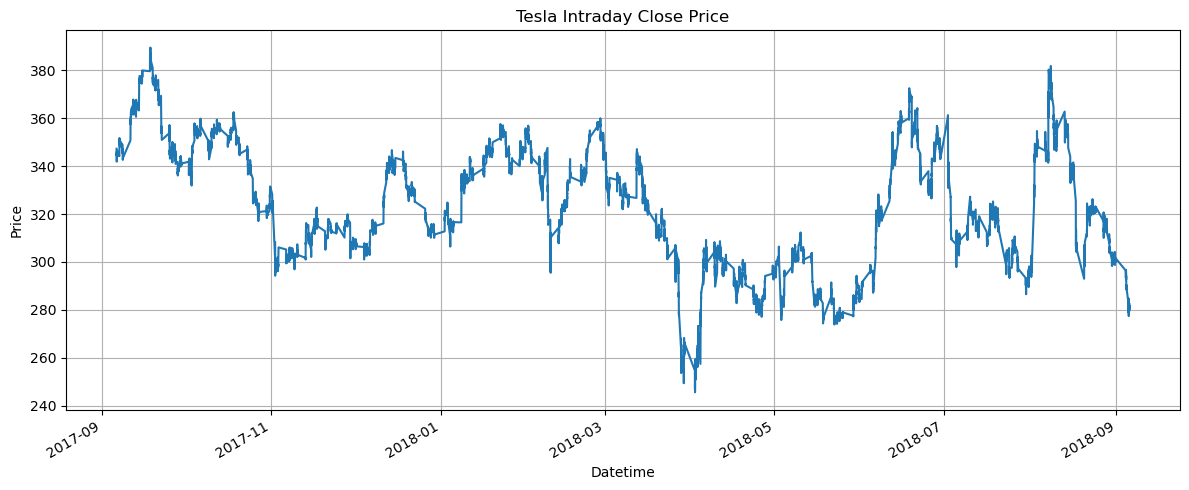

In [265]:
tesla['Close'].plot(figsize=(12, 5), title="Tesla Intraday Close Price")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

### Simple buy at open and sell at close trading strategy

In [268]:
# After (Correct)
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)
tesla = tesla.set_index('Datetime')

# --- Strategy Implementation ---
# Resample the 5-minute data to a daily frequency ('D')
# 'first' gets the first value of the day (the open)
# 'last' gets the last value of the day (the close)
daily_trades = tesla['Open'].resample('D').first().to_frame(name='Day_Open')
daily_trades['Day_Close'] = tesla['Close'].resample('D').last()

# Drop days where the market was closed (no trades)
daily_trades.dropna(inplace=True)

# Calculate the daily and cumulative Profit and Loss (PnL) for one share
daily_trades['PnL'] = daily_trades['Day_Close'] - daily_trades['Day_Open']
daily_trades['Cumulative_PnL'] = daily_trades['PnL'].cumsum()

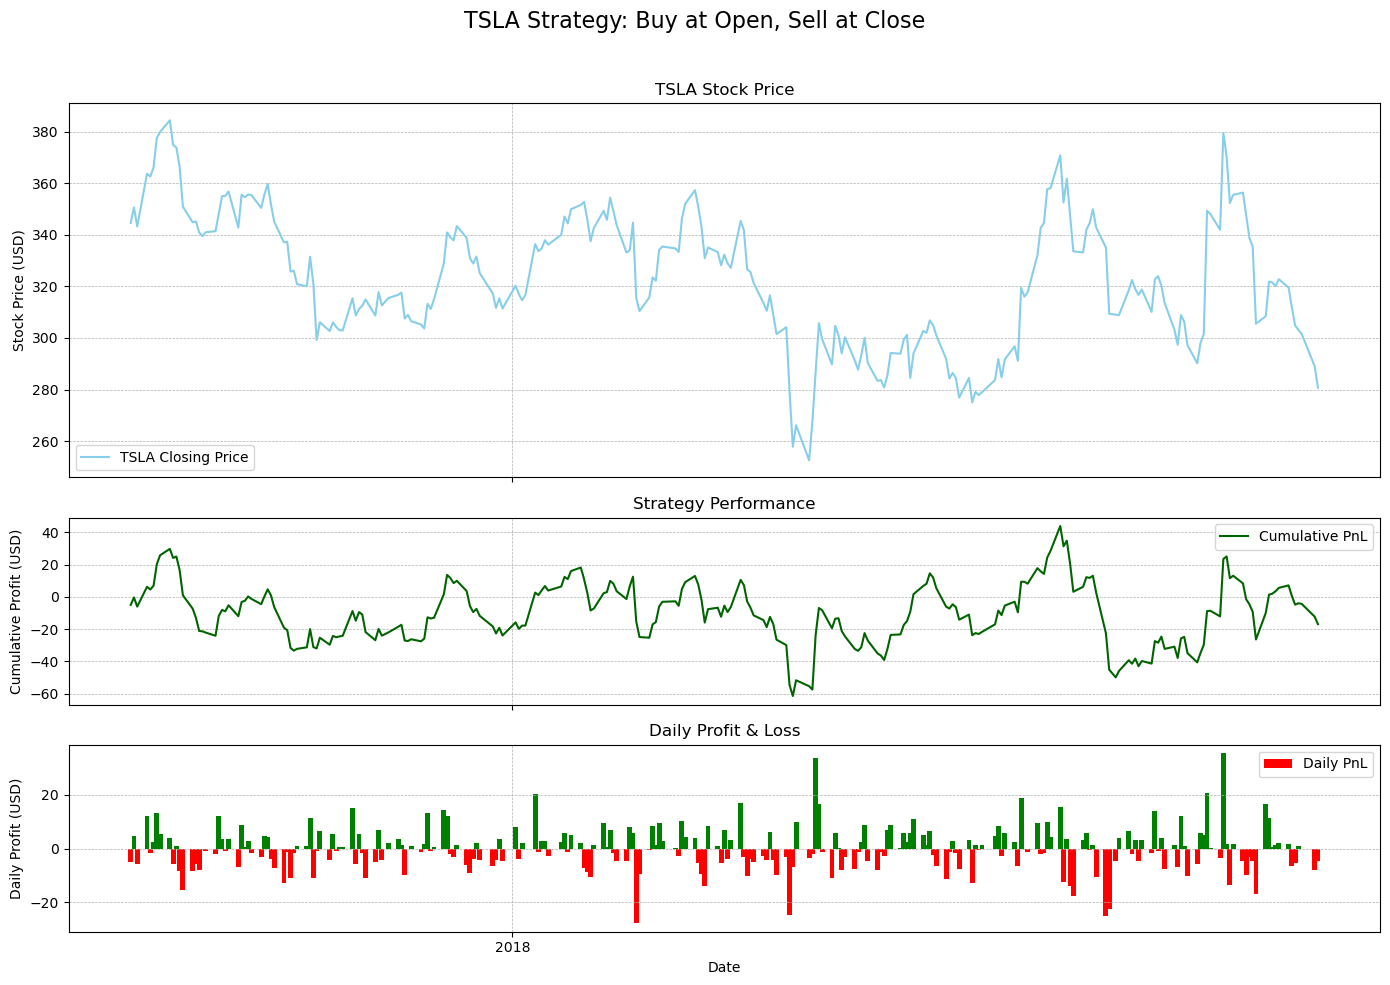

In [270]:
# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                                    gridspec_kw={'height_ratios': [2, 1, 1]})
fig.suptitle('TSLA Strategy: Buy at Open, Sell at Close', fontsize=16)

# Panel 1: Stock Price
ax1.plot(daily_trades.index, daily_trades['Day_Close'], label='TSLA Closing Price', color='skyblue')
ax1.set_ylabel('Stock Price (USD)')
ax1.set_title('TSLA Stock Price')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Panel 2: Cumulative PnL
ax2.plot(daily_trades.index, daily_trades['Cumulative_PnL'], label='Cumulative PnL', color='darkgreen')
ax2.set_ylabel('Cumulative Profit (USD)')
ax2.set_title('Strategy Performance')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend()

# Panel 3: Daily PnL
colors = ['g' if x > 0 else 'r' for x in daily_trades['PnL']]
ax3.bar(daily_trades.index, daily_trades['PnL'], color=colors, label='Daily PnL', width=1.5)
ax3.set_ylabel('Daily Profit (USD)')
ax3.set_title('Daily Profit & Loss')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.legend()

# Improve x-axis formatting
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Buy or sell when certain price deviation happens close at the end of the day. 

In [273]:
# Prepare the datetime index
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)
tesla = tesla.set_index('Datetime')

# Group data by day
grouped = tesla.groupby(tesla.index.date)

# Store daily trades
trade_results = []

for date, group in grouped:
    group = group.sort_index()  # Ensure chronological order
    
    day_open = group.iloc[0]['Open']
    day_close = group.iloc[-1]['Close']
    threshold_price = day_open * 1.005  # 0.5% increase
    
    # Look for first price that crosses threshold
    crossed = group[group['High'] >= threshold_price]
    
    if not crossed.empty:
        # Buy triggered at first threshold cross
        buy_time = crossed.index[0]
        buy_price = day_open  # As per your rule, buy at open if threshold is met later
        sell_price = day_close  # Sell at day close
        
        pnl = sell_price - buy_price
    else:
        # No trade that day
        pnl = 0.0
    
    trade_results.append({
        'Date': pd.to_datetime(date),
        'Day_Open': day_open,
        'Day_Close': day_close,
        'PnL': pnl
    })

# Convert to DataFrame
daily_trades = pd.DataFrame(trade_results)
daily_trades.set_index('Date', inplace=True)
daily_trades['Cumulative_PnL'] = daily_trades['PnL'].cumsum()

# Inspect result
print(daily_trades.head())

            Day_Open  Day_Close    PnL  Cumulative_PnL
Date                                                  
2017-09-06    349.65     344.66   0.00            0.00
2017-09-07    345.98     350.61   4.63            4.63
2017-09-08    348.99     343.30   0.00            4.63
2017-09-11    351.42     363.70  12.28           16.91
2017-09-12    364.31     362.64  -1.67           15.24


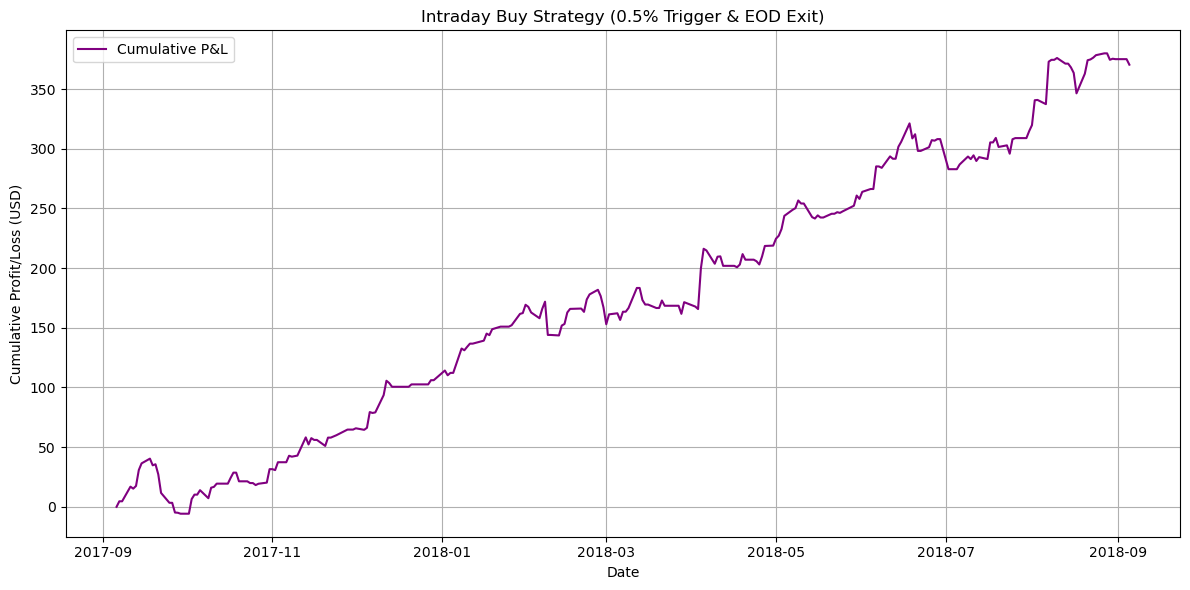

In [275]:
plt.figure(figsize=(12, 6))
plt.plot(daily_trades.index, daily_trades['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Intraday Buy Strategy (0.5% Trigger & EOD Exit)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [277]:
trade_days = daily_trades[daily_trades['PnL'] != 0]

print(f"Total Profit/Loss: ${trade_days['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${trade_days['PnL'].mean():.2f}")
print(f"Number of Trades: {len(trade_days)}")
print(f"Winning Trades: {(trade_days['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trade_days['PnL'] < 0).sum()}")

Total Profit/Loss: $370.45
Average Trade PnL: $1.89
Number of Trades: 196
Winning Trades: 122
Losing Trades: 74


### Adjusted conditional strategy with buy fix and stop loss

In [280]:
threshold = 0.7      # % move to trigger entry
stop_loss_pct = 1.5  # % stop loss
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Group by trading day
grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']
    threshold_price_up = day_open * (1 + threshold / 100)
    threshold_price_down = day_open * (1 - threshold / 100)
    
    stop_loss_long = day_open * (1 - stop_loss_pct / 100)
    stop_loss_short = day_open * (1 + stop_loss_pct / 100)

    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]
        
        # ----- Long trade -----
        if not trade_triggered and current['High'] >= threshold_price_up:
            trade_triggered = True
            tesla.at[idx, 'Position'] = 'Long'
            
            # Look forward to simulate stop-loss or close
            for j in range(i, len(group)):
                forward = group.iloc[j]
                forward_idx = group.index[j]
                
                if forward['Low'] <= stop_loss_long:
                    # Stop loss hit
                    stop_price = stop_loss_long
                    pnl = stop_price - day_open
                    tesla.at[idx, 'PnL'] = pnl
                    break
            else:
                # No stop loss hit, exit at close of day
                final_close = group.iloc[-1]['Close']
                pnl = final_close - day_open
                tesla.at[idx, 'PnL'] = pnl
            break  # only one trade per day
        
        # ----- Short trade -----
        elif not trade_triggered and current['Low'] <= threshold_price_down:
            trade_triggered = True
            tesla.at[idx, 'Position'] = 'Short'
            
            for j in range(i, len(group)):
                forward = group.iloc[j]
                forward_idx = group.index[j]
                
                if forward['High'] >= stop_loss_short:
                    stop_price = stop_loss_short
                    pnl = day_open - stop_price
                    tesla.at[idx, 'PnL'] = pnl
                    break
            else:
                final_close = group.iloc[-1]['Close']
                pnl = day_open - final_close
                tesla.at[idx, 'PnL'] = pnl
            break

# Compute return and cumulative PnL
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

In [282]:
trade_entries = tesla[tesla['Position'] != 'None'].copy()

trade_entries['Trade_Date'] = trade_entries.index.date
daily_summary = trade_entries.groupby('Trade_Date').agg({
    'PnL': 'sum'  # Only one trade per day in current strategy
})
daily_summary['Cumulative_PnL'] = daily_summary['PnL'].cumsum()

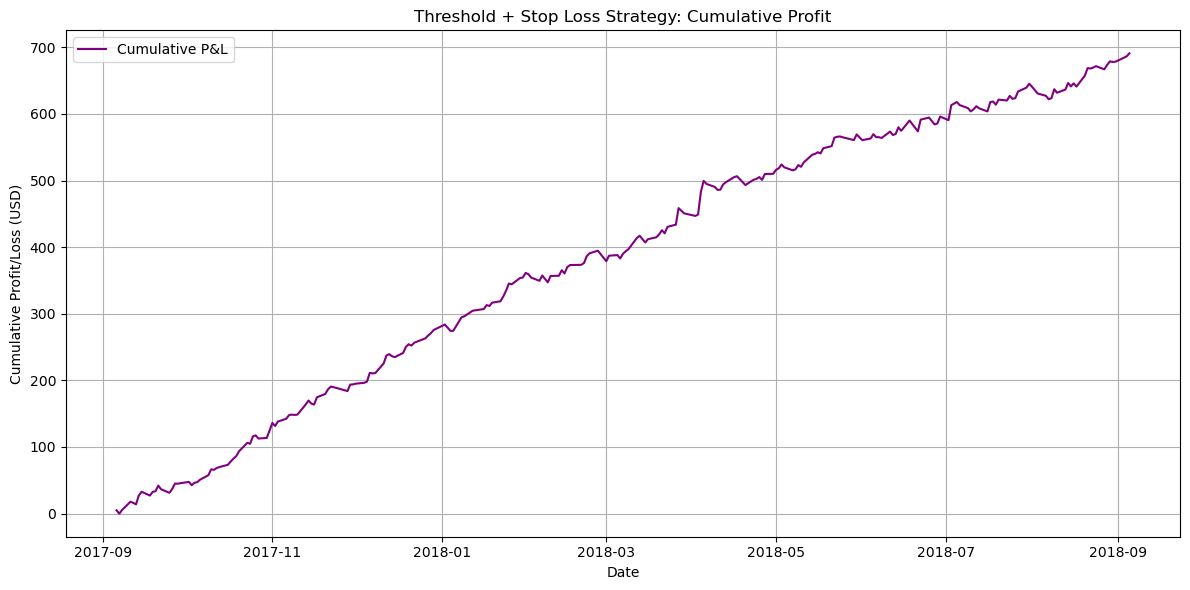

In [284]:
plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['Cumulative_PnL'], color='purple', label='Cumulative P&L')
plt.title('Threshold + Stop Loss Strategy: Cumulative Profit')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [286]:
trades = tesla[tesla['Position'] != 'None']

In [288]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${tesla.loc[tesla['Position'] != 'None', 'PnL'].mean():.2f}")
print(f"Average Percent Return per Trade: {trades['ReturnPctTrade'].mean():.4f}%")
print(f"Max Return: {trades['ReturnPctTrade'].max():.2f}%")
print(f"Min Return: {trades['ReturnPctTrade'].min():.2f}%")
print(f"Number of Trades: {(tesla['Position'] != 'None').sum()}")
print(f"Winning Trades: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Trades: {(tesla['PnL'] < 0).sum()}")

Total Profit/Loss: $690.97
Average Trade PnL: $2.74
Average Percent Return per Trade: 0.8607%
Max Return: 13.37%
Min Return: -1.51%
Number of Trades: 252
Winning Trades: 165
Losing Trades: 87


### Strategies performance vs buy and hold

In [291]:
total_profit = tesla.loc[tesla['Position'] != 'None', 'PnL'].sum()

In [293]:
# Total capital used (sum of open prices on trade days, 1 share per trade)
total_cost = tesla.loc[tesla['Position'] != 'None', 'Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

In [295]:
# Buy first candle, hold until last candle
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']

buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100

In [301]:
# Strategy return
trades = tesla[tesla['Position'] != 'None']
total_profit = trades['PnL'].sum()
total_cost = trades['Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

# Buy-and-hold return
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']
buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100
buy_and_hold_cost = first_price  # capital deployed in B&H (1 share)

# Print summary
print("=== Strategy Performance ===")
print(f"Total Profit from Strategy: ${total_profit:.2f}")
print(f"Total Capital Deployed: ${total_cost:.2f}")
print(f"Total Return (Strategy): {total_return_pct:.2f}%")

print("\n=== Buy & Hold Performance ===")
print(f"Total Profit from Buy & Hold: ${buy_and_hold_profit:.2f}")
print(f"Capital Deployed (Buy & Hold): ${buy_and_hold_cost:.2f}")
print(f"Total Return (Buy & Hold): {buy_and_hold_return_pct:.2f}%")


=== Strategy Performance ===
Total Profit from Strategy: $690.97
Total Capital Deployed: $81381.01
Total Return (Strategy): 0.85%

=== Buy & Hold Performance ===
Total Profit from Buy & Hold: $-68.95
Capital Deployed (Buy & Hold): $349.65
Total Return (Buy & Hold): -19.72%


### Adding take profit logic

In [304]:
threshold = 0.6        # % move to trigger trade
stop_loss_pct = 1.0    # % stop loss
take_profit_pct = 5.0  # % take profit

# Reset
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Group by trading day
grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']
    
    # Entry thresholds
    threshold_up = day_open * (1 + threshold / 100)
    threshold_down = day_open * (1 - threshold / 100)
    
    # SL and TP levels
    sl_long = day_open * (1 - stop_loss_pct / 100)
    tp_long = day_open * (1 + take_profit_pct / 100)
    
    sl_short = day_open * (1 + stop_loss_pct / 100)
    tp_short = day_open * (1 - take_profit_pct / 100)
    
    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]
        
        # Long entry
        if not trade_triggered and current['High'] >= threshold_up:
            tesla.at[idx, 'Position'] = 'Long'
            trade_triggered = True
            
            for j in range(i, len(group)):
                forward = group.iloc[j]
                
                # Hit Stop-Loss
                if forward['Low'] <= sl_long:
                    tesla.at[idx, 'PnL'] = sl_long - day_open
                    break
                # Hit Take-Profit
                elif forward['High'] >= tp_long:
                    tesla.at[idx, 'PnL'] = tp_long - day_open
                    break
            else:
                # Exit at end-of-day close
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = final_close - day_open
            break  # one trade per day

        # Short entry
        elif not trade_triggered and current['Low'] <= threshold_down:
            tesla.at[idx, 'Position'] = 'Short'
            trade_triggered = True

            for j in range(i, len(group)):
                forward = group.iloc[j]
                
                if forward['High'] >= sl_short:
                    tesla.at[idx, 'PnL'] = day_open - sl_short
                    break
                elif forward['Low'] <= tp_short:
                    tesla.at[idx, 'PnL'] = day_open - tp_short
                    break
            else:
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = day_open - final_close
            break


In [305]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")


Total Profit: $569.56
Average % Return per Trade: 0.70%
Winning Trades: 144
Losing Trades: 108


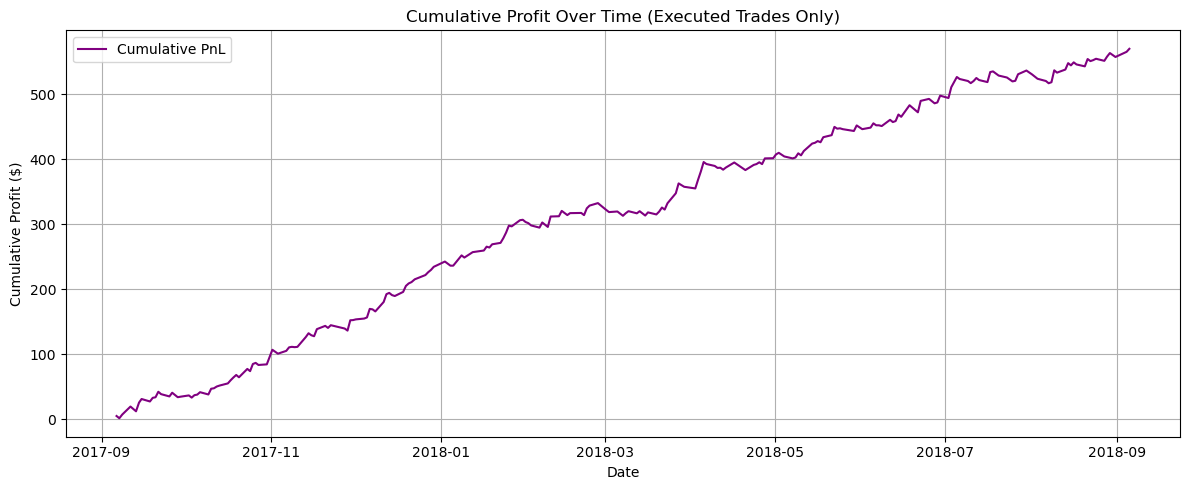

In [308]:
plt.figure(figsize=(12, 5))
plt.plot(trades.index, trades['PnL'].cumsum(), label='Cumulative PnL', color='purple')
plt.title('Cumulative Profit Over Time (Executed Trades Only)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Add trading cost to the strategy

In [311]:
threshold = 2.1       # % move to trigger trade
stop_loss_pct = 1.0    # % stop loss
take_profit_pct = 8.0  # % take profit
trading_cost = 0.30

# Reset
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Group by trading day
grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']
    
    # Entry thresholds
    threshold_up = day_open * (1 + threshold / 100)
    threshold_down = day_open * (1 - threshold / 100)
    
    # SL and TP levels
    sl_long = day_open * (1 - stop_loss_pct / 100)
    tp_long = day_open * (1 + take_profit_pct / 100)
    
    sl_short = day_open * (1 + stop_loss_pct / 100)
    tp_short = day_open * (1 - take_profit_pct / 100)
    
    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]
        
        # Long entry
        if not trade_triggered and current['High'] >= threshold_up:
            tesla.at[idx, 'Position'] = 'Long'
            trade_triggered = True
            
            for j in range(i, len(group)):
                forward = group.iloc[j]
                
                # Hit Stop-Loss
                if forward['Low'] <= sl_long:
                    tesla.at[idx, 'PnL'] = sl_long - day_open - trading_cost
                    break
                # Hit Take-Profit
                elif forward['High'] >= tp_long:
                    tesla.at[idx, 'PnL'] = tp_long - day_open - trading_cost
                    break
            else:
                # Exit at end-of-day close
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = final_close - day_open - trading_cost
            break  # one trade per day

        # Short entry
        elif not trade_triggered and current['Low'] <= threshold_down:
            tesla.at[idx, 'Position'] = 'Short'
            trade_triggered = True

            for j in range(i, len(group)):
                forward = group.iloc[j]
                
                if forward['High'] >= sl_short:
                    tesla.at[idx, 'PnL'] = day_open - sl_short - trading_cost
                    break
                elif forward['Low'] <= tp_short:
                    tesla.at[idx, 'PnL'] = day_open - tp_short - trading_cost
                    break
            else:
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = day_open - final_close - trading_cost
            break


In [312]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")

Total Profit: $1109.31
Average % Return per Trade: 2.16%
Winning Trades: 139
Losing Trades: 20


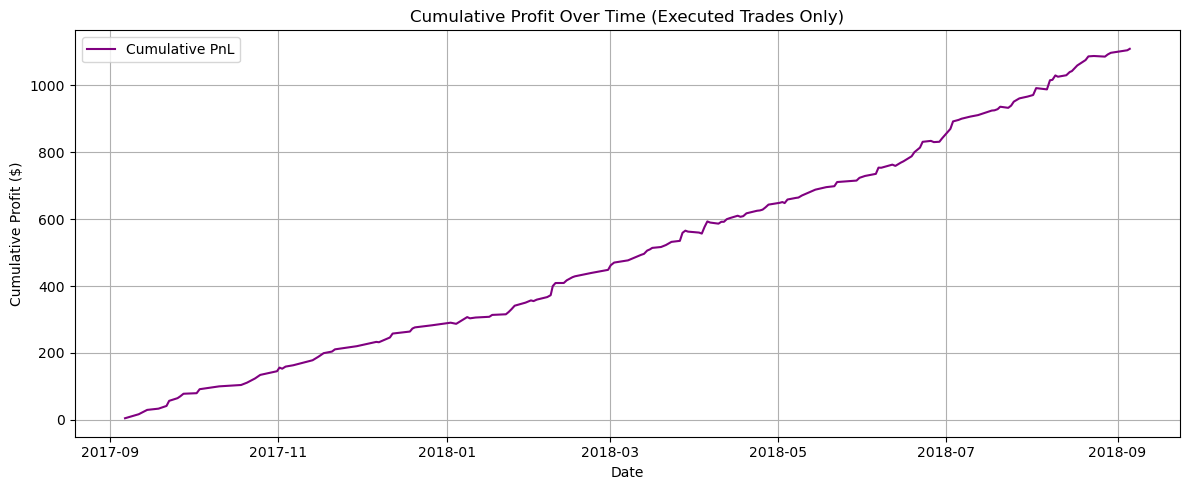

In [315]:
plt.figure(figsize=(12, 5))
plt.plot(trades.index, trades['PnL'].cumsum(), label='Cumulative PnL', color='purple')
plt.title('Cumulative Profit Over Time (Executed Trades Only)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()